## Imports and Data load

In [196]:
%pip install sweetviz
%pip install scikit-learn==1.1.3
%pip install catboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [207]:
import pandas as pd
import sweetviz as sv
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv

from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.utils import shuffle

from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

In [135]:
RANDOM_STATE = 1220

In [136]:
train_data = pd.read_csv('/home/dolin/Titanic_kagle/Data/train.csv')
test_features = pd.read_csv('/home/dolin/Titanic_kagle/Data/test.csv')

test_target = pd.read_csv('/home/dolin/Titanic_kagle/Data/gender_submission.csv')

In [137]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [138]:
test_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## EDA

Let's write a simple function to quickly review data

In [139]:
def info_df(df):
    plt.figure(figsize=(15, 13))
    sb.heatmap(df.corr(), cmap="YlGnBu", annot=True);
    print('------------------------------')
    print('|    Dataset information.    |')
    print('------------------------------')
    df.info()
    print('------------------------------')
    print('|        First 10 rows.      |')
    print('------------------------------')
    print(df.head(10))
    print('---------------------------------')
    print('|        Last 10 rows.          |')
    print('---------------------------------')
    print(df.tail(10))
    print('---------------------------')
    print('| Descriptive statistics. |')
    print('---------------------------')
    print(df.describe())
    print('----------------------')
    print('| Sum of duplicates. |')
    print('----------------------')
    print(df.duplicated().sum())
    print('--------------------------')
    print('|    Covariance matrix.  |')
    print('--------------------------')
    plt.show()

------------------------------
|    Dataset information.    |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
------------------------------
|        First 10 rows.      |
------------------------------
   PassengerId  Survived  Pclass  \
0            1        

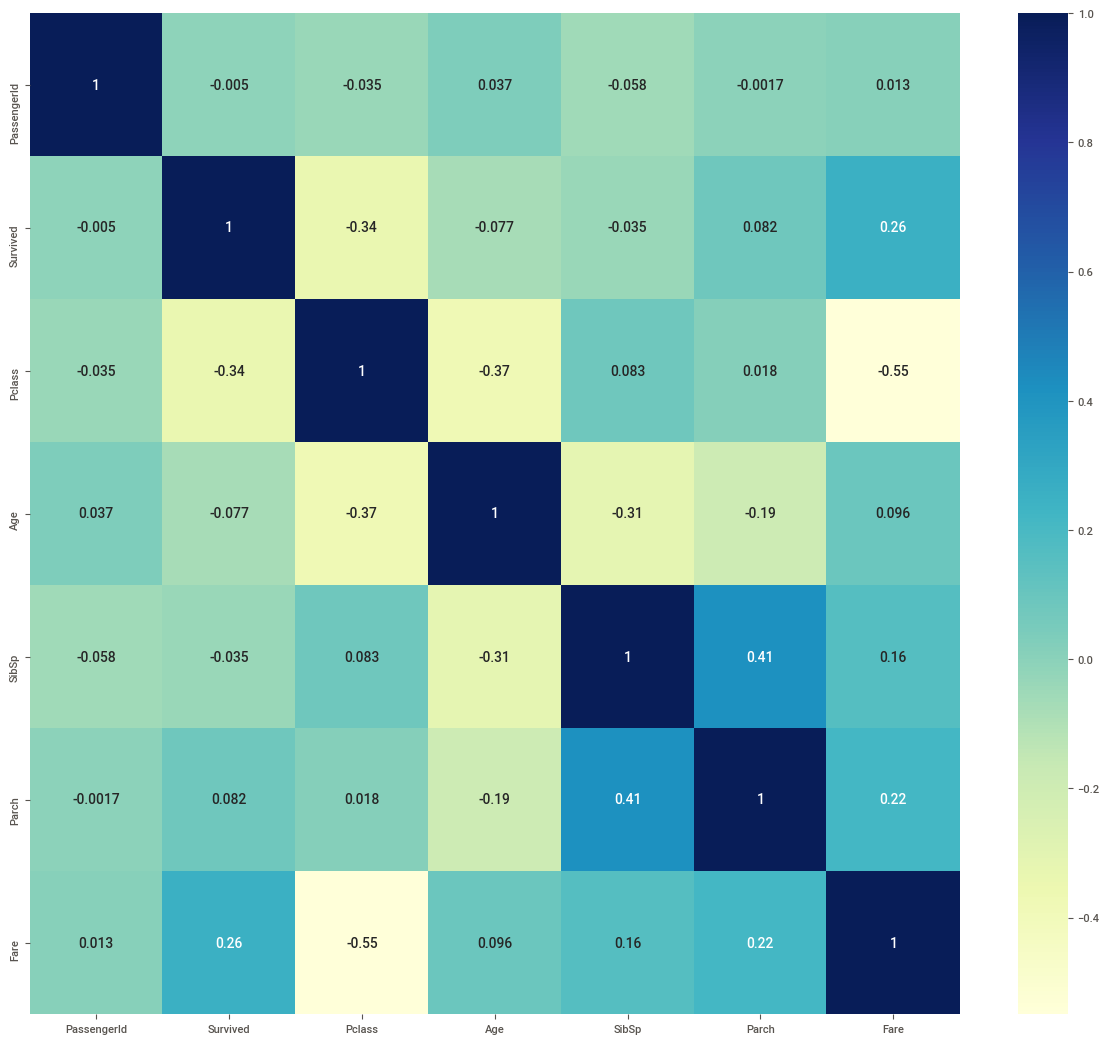

In [140]:
info_df(train_data)

In [141]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,19.900000
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


------------------------------
|    Dataset information.    |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
------------------------------
|        First 10 rows.      |
------------------------------
   PassengerId  Pclass                                          Name     Sex  \
0          892      

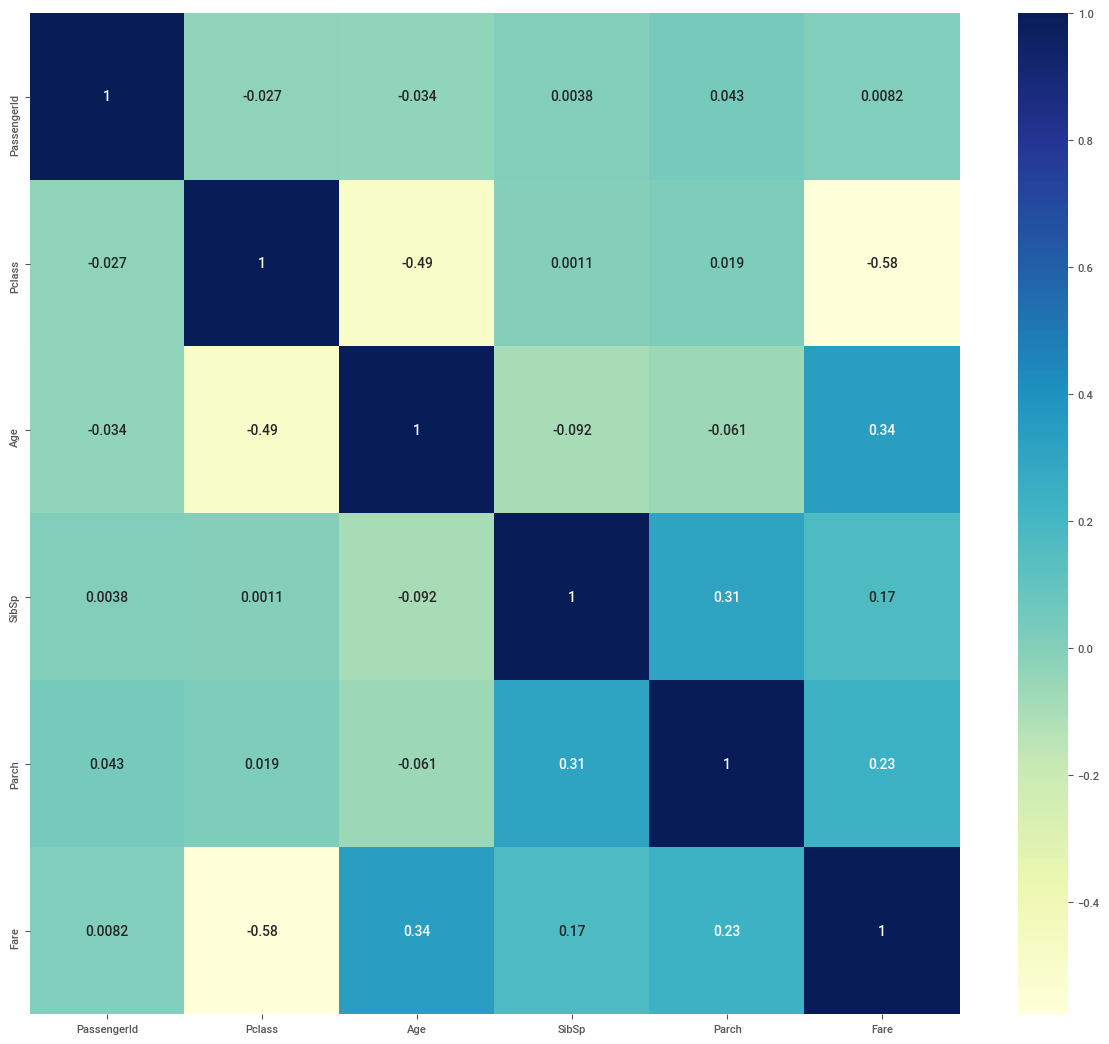

In [142]:
info_df(test_features)

In [143]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(test_features.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
PassengerId,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,20.600000
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.200000
Cabin,78.200000


We can see that in columns `Age`, `Cabin` and `Embarked` has a gaps in data. And also `Age` has a different data type (Float64). Let's make change to these mistakes!

**Rename titels**

In [144]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [145]:
columns = {}
for i in train_data.columns:
    columns[i] = i.lower()
train_data = train_data.rename(columns=columns)
test_features = test_features.rename(columns=columns)

**Duplicates**

In [146]:
train_data = train_data.drop('passengerid', axis = 1)
train_data.duplicated().sum()

0

In [147]:
test_features = test_features.drop('passengerid', axis = 1)
test_features.duplicated().sum()

0

**Implicit Duplicates**

Consider possible implicit duplicates

In [148]:
for i in ['sex', 'sibsp','ticket', 'cabin','embarked']:
    print(i)
    print('------------------------------------------------------------')
    print(train_data[i].unique())
    print('------------------------------------------------------------')

sex
------------------------------------------------------------
['male' 'female']
------------------------------------------------------------
sibsp
------------------------------------------------------------
[1 0 3 4 2 5 8]
------------------------------------------------------------
ticket
------------------------------------------------------------
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649' '239865'
 '248698' '330923' '113788' '347077' '2631' '19950' '330959' '349216'
 'PC 17601' 'PC 17569' '335677' 'C.A. 24579' 'PC 17604' '113789' '2677'
 'A./5. 2152' '345764' '2651' '7546' '11668' '349253' 'SC/Paris 2123'
 '330958' 'S.C./A.4. 23567' '370371' '14311' '2662' '349237' '3101295'
 'A/4. 39886' 'PC 17572' '2926' '113509' '19947' 'C.A. 31026' '2697'
 'C.A. 34651' 'CA 2144' '2669' '113572' '36973' '347088' 'PC 17605' '2661'
 'C.A. 29

As you can see, tickets, cabin and embarker has a mistakes and ambiguity.

**Tickets**

First of all, let's have look on the tickets. We can replace code name and number of the tickets  and leave only number, because code name does not provide useful information. Also we can drop it, and... just do it, because, in my opinion, it is not useful information for our models, like a name.

P.S. In fact, there is useful information, but is this case i suggest relyimg on the type of cabin 

In [149]:
train_data = train_data.drop(['ticket','name'], axis = 1)
test_features = test_features.drop(['ticket','name'], axis = 1)

**Fill in the blanks**

I think its not a big deal and we can fill blanks the median value.

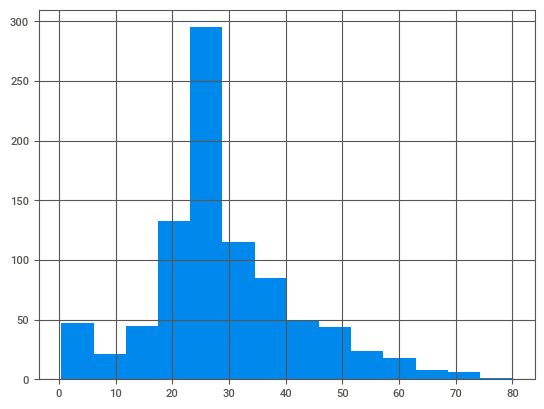

In [150]:
train_data['age'] = train_data['age'].fillna(train_data['age'].median())
train_data['age'].hist(bins=14);

**Cabin**

This point is ambiguous. Because the type of room really could affect survival. But we have a lot of gaps in this column. 

I suggest make a pivot table or just a look on dependency of data between type of room and passenger fare

But before that let's make a replace inplicit duplicates.

In [151]:
train_data['cabin'].sort_values().unique()

array(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31',
       'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'B101', 'B102', 'B18',
       'B19', 'B20', 'B22', 'B28', 'B3', 'B30', 'B35', 'B37', 'B38',
       'B39', 'B4', 'B41', 'B42', 'B49', 'B5', 'B50', 'B51 B53 B55',
       'B57 B59 B63 B66', 'B58 B60', 'B69', 'B71', 'B73', 'B77', 'B78',
       'B79', 'B80', 'B82 B84', 'B86', 'B94', 'B96 B98', 'C101', 'C103',
       'C104', 'C106', 'C110', 'C111', 'C118', 'C123', 'C124', 'C125',
       'C126', 'C128', 'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C30',
       'C32', 'C45', 'C46', 'C47', 'C49', 'C50', 'C52', 'C54', 'C62 C64',
       'C65', 'C68', 'C7', 'C70', 'C78', 'C82', 'C83', 'C85', 'C86',
       'C87', 'C90', 'C91', 'C92', 'C93', 'C95', 'C99', 'D', 'D10 D12',
       'D11', 'D15', 'D17', 'D19', 'D20', 'D21', 'D26', 'D28', 'D30',
       'D33', 'D35', 'D36', 'D37', 'D45', 'D46', 'D47', 'D48', 'D49',
       'D50', 'D56', 'D6', 'D7', 'D9', 'E10', 'E101', 'E12', 'E121',
       'E17',

In [152]:
test_features['cabin'].sort_values().unique()

array(['A11', 'A18', 'A21', 'A29', 'A34', 'A9', 'B10', 'B11', 'B24',
       'B26', 'B36', 'B41', 'B45', 'B51 B53 B55', 'B52 B54 B56',
       'B57 B59 B63 B66', 'B58 B60', 'B61', 'B69', 'B71', 'B78', 'C101',
       'C105', 'C106', 'C116', 'C130', 'C132', 'C22 C26', 'C23 C25 C27',
       'C28', 'C31', 'C32', 'C39', 'C46', 'C51', 'C53', 'C54', 'C55 C57',
       'C6', 'C62 C64', 'C7', 'C78', 'C80', 'C85', 'C86', 'C89', 'C97',
       'D', 'D10 D12', 'D15', 'D19', 'D21', 'D22', 'D28', 'D30', 'D34',
       'D37', 'D38', 'D40', 'D43', 'E31', 'E34', 'E39 E41', 'E45', 'E46',
       'E50', 'E52', 'E60', 'F', 'F E46', 'F E57', 'F G63', 'F2', 'F33',
       'F4', 'G6', nan], dtype=object)

Right now we have a 3 ways.
- The first way, we can replace stuck together cabins on single type like B57 B59 etc. to B (median number).
- The second way, we can split this cabins, and attempt recover based on tickets.
- The thierd way, we can drop it. 

In your case choose you way. But i am choose the first.

In [153]:
train_data = train_data.apply(lambda x: x.replace({'C2 C2 C2':'C2', 'F G73': 'G73', 'F E69': 'E69',
                                                     'C2 C2':'C2', 'F G63': 'G63','B51 B53 B55': 'B53', 
                                                     'B57 B59 B63 B66': 'B61', 'B58 B60': 'B59', 'B82 B84': 'B81', 
                                                     'B96 B98': 'B97', 'C62 C64': 'C63', 'D10 D12': 'D11',
                                                     'C22 C26': 'C24', 'C23 C25 C27': 'C25'}, regex=True))

In [154]:
test_features = test_features.apply(lambda x: x.replace({'B51 B53 B55': 'B53', 'B52 B54 B56': 'B54', 
                                                         'B57 B59 B63 B66': 'B61','B58 B60': 'B59', 'C22 C26': 'C24',
                                                         'C23 C25 C27': 'C25','C55 C57':'C56','C62 C64': 'C63', 
                                                         'D10 D12': 'D11', 'E39 E41': 'E40', 'F E46': 'E46', 'F E57': 'E57',
                                                         'F G63': 'G63'}, regex=True))

In [155]:
train_data = train_data.dropna()

In [156]:
train_data['cabin'].sort_values().unique()

array(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31',
       'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'B101', 'B102', 'B18',
       'B19', 'B20', 'B22', 'B3', 'B30', 'B35', 'B37', 'B38', 'B39', 'B4',
       'B41', 'B42', 'B49', 'B5', 'B50', 'B53', 'B59', 'B61', 'B69',
       'B71', 'B73', 'B77', 'B78', 'B79', 'B80', 'B81', 'B86', 'B94',
       'B97', 'C101', 'C103', 'C104', 'C106', 'C110', 'C111', 'C118',
       'C123', 'C124', 'C125', 'C126', 'C128', 'C148', 'C2', 'C24', 'C25',
       'C30', 'C32', 'C45', 'C46', 'C47', 'C49', 'C50', 'C52', 'C54',
       'C63', 'C65', 'C68', 'C7', 'C70', 'C78', 'C82', 'C83', 'C85',
       'C86', 'C87', 'C90', 'C91', 'C92', 'C93', 'C95', 'C99', 'D', 'D11',
       'D15', 'D17', 'D19', 'D20', 'D21', 'D26', 'D28', 'D30', 'D33',
       'D35', 'D36', 'D37', 'D45', 'D46', 'D47', 'D48', 'D49', 'D50',
       'D56', 'D6', 'D7', 'D9', 'E10', 'E101', 'E12', 'E121', 'E17',
       'E24', 'E25', 'E31', 'E33', 'E34', 'E36', 'E38', 'E40', 'E44',
       'E

In [157]:
test_features['cabin'].sort_values().unique()

array(['A11', 'A18', 'A21', 'A29', 'A34', 'A9', 'B10', 'B11', 'B24',
       'B26', 'B36', 'B41', 'B45', 'B53', 'B54', 'B59', 'B61', 'B69',
       'B71', 'B78', 'C101', 'C105', 'C106', 'C116', 'C130', 'C132',
       'C24', 'C25', 'C28', 'C31', 'C32', 'C39', 'C46', 'C51', 'C53',
       'C54', 'C56', 'C6', 'C63', 'C7', 'C78', 'C80', 'C85', 'C86', 'C89',
       'C97', 'D', 'D11', 'D15', 'D19', 'D21', 'D22', 'D28', 'D30', 'D34',
       'D37', 'D38', 'D40', 'D43', 'E31', 'E34', 'E40', 'E45', 'E46',
       'E50', 'E52', 'E57', 'E60', 'F', 'F2', 'F33', 'F4', 'G6', 'G63',
       nan], dtype=object)

Let's separate the cabin type and cabin number and create two new  features.

In [158]:
def split_test_cabin_type(row):
    if row:
        return re.findall(r'[a-zA-Z]+',str(row))[0]
    else:
        pass

In [159]:
def split_test_cabin_number(row):
    if pd.notna(row) and len(row) > 1:
        return int(row[1:])
    else:
        pass

In [160]:
train_data['type_cabin'] = train_data['cabin'].apply(lambda str: re.findall(r'[a-zA-Z]+',str)[0])
train_data['number_cabin'] = train_data['cabin'].apply(lambda str: int(*(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?",str))))


test_features['type_cabin'] = test_features['cabin'].apply(split_test_cabin_type)
test_features['number_cabin'] = test_features['cabin'].apply(split_test_cabin_number)

In [161]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202 entries, 1 to 889
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   survived      202 non-null    int64  
 1   pclass        202 non-null    int64  
 2   sex           202 non-null    object 
 3   age           202 non-null    float64
 4   sibsp         202 non-null    int64  
 5   parch         202 non-null    int64  
 6   fare          202 non-null    float64
 7   cabin         202 non-null    object 
 8   embarked      202 non-null    object 
 9   type_cabin    202 non-null    object 
 10  number_cabin  202 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 18.9+ KB


In [162]:
train_data['type_cabin']

1      C
3      C
6      E
10     G
11     C
      ..
871    D
872    B
879    C
887    B
889    C
Name: type_cabin, Length: 202, dtype: object

In [163]:
train_data['number_cabin']

1       85
3      123
6       46
10       6
11     103
      ... 
871     35
872     53
879     50
887     42
889    148
Name: number_cabin, Length: 202, dtype: int64

In [164]:
train_data = train_data.drop('cabin', axis = 1)
train_data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,type_cabin,number_cabin
1,1,1,female,38.0,1,0,71.2833,C,C,85
3,1,1,female,35.0,1,0,53.1000,S,C,123
6,0,1,male,54.0,0,0,51.8625,S,E,46
10,1,3,female,4.0,1,1,16.7000,S,G,6
11,1,1,female,58.0,0,0,26.5500,S,C,103
...,...,...,...,...,...,...,...,...,...,...
871,1,1,female,47.0,1,1,52.5542,S,D,35
872,0,1,male,33.0,0,0,5.0000,S,B,53
879,1,1,female,56.0,0,1,83.1583,C,C,50
887,1,1,female,19.0,0,0,30.0000,S,B,42


In [165]:
test_features = test_features.drop('cabin', axis = 1)
test_features

,pclass,sex,age,sibsp,parch,fare,embarked,type_cabin,number_cabin
0,3,male,34.5,0,0,7.8292,Q,nan,NaN
1,3,female,47.0,1,0,7.0000,S,nan,NaN
2,2,male,62.0,0,0,9.6875,Q,nan,NaN
3,3,male,27.0,0,0,8.6625,S,nan,NaN
4,3,female,22.0,1,1,12.2875,S,nan,NaN
...,...,...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S,nan,NaN
414,1,female,39.0,0,0,108.9000,C,C,105.0
415,3,male,38.5,0,0,7.2500,S,nan,NaN
416,3,male,NaN,0,0,8.0500,S,nan,NaN


**Convert Float to Int and Int to Int**

This point in particularly not important, but i wanna say, that you need learn save you RAM.

In [166]:
train_data[['survived', 'pclass', 'sibsp', 'parch', 'age']] = train_data[['survived', 'pclass', 'sibsp', 'parch', 'age']].astype('int16')
test_features[['pclass', 'sibsp', 'parch', 'age']] = pd.notna(test_features[['pclass', 'sibsp', 'parch', 'age']]).astype('int16')

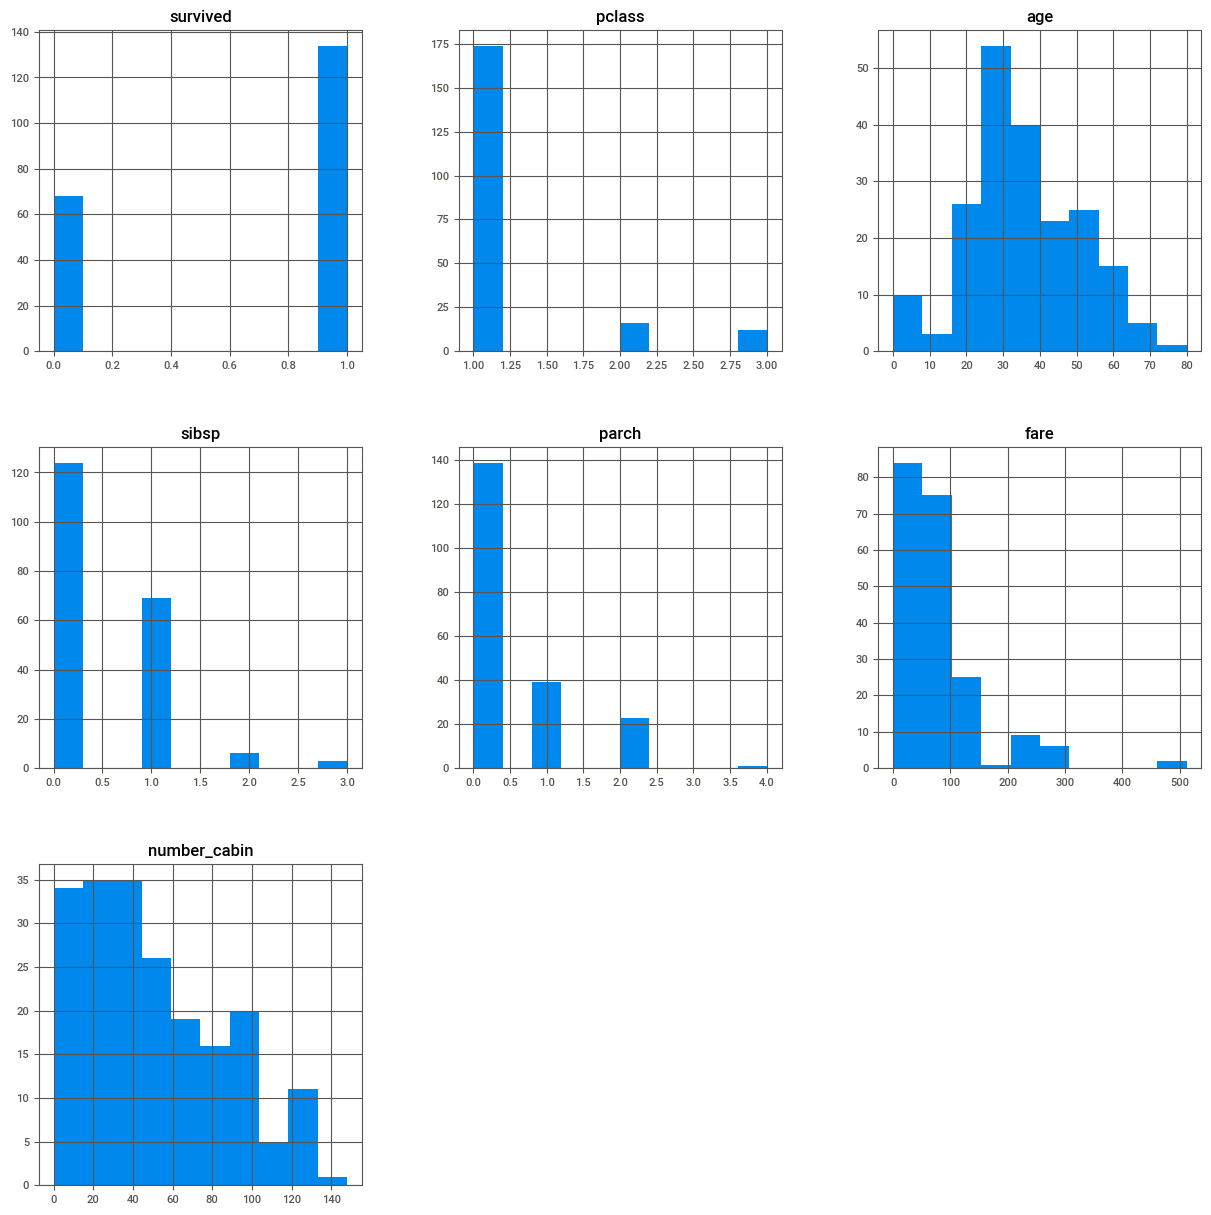

In [167]:
train_data.hist(figsize=(15,15));

In [168]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
survived,0.000000
pclass,0.000000
sex,0.000000
age,0.000000
sibsp,0.000000
parch,0.000000
fare,0.000000
embarked,0.000000
type_cabin,0.000000
number_cabin,0.000000


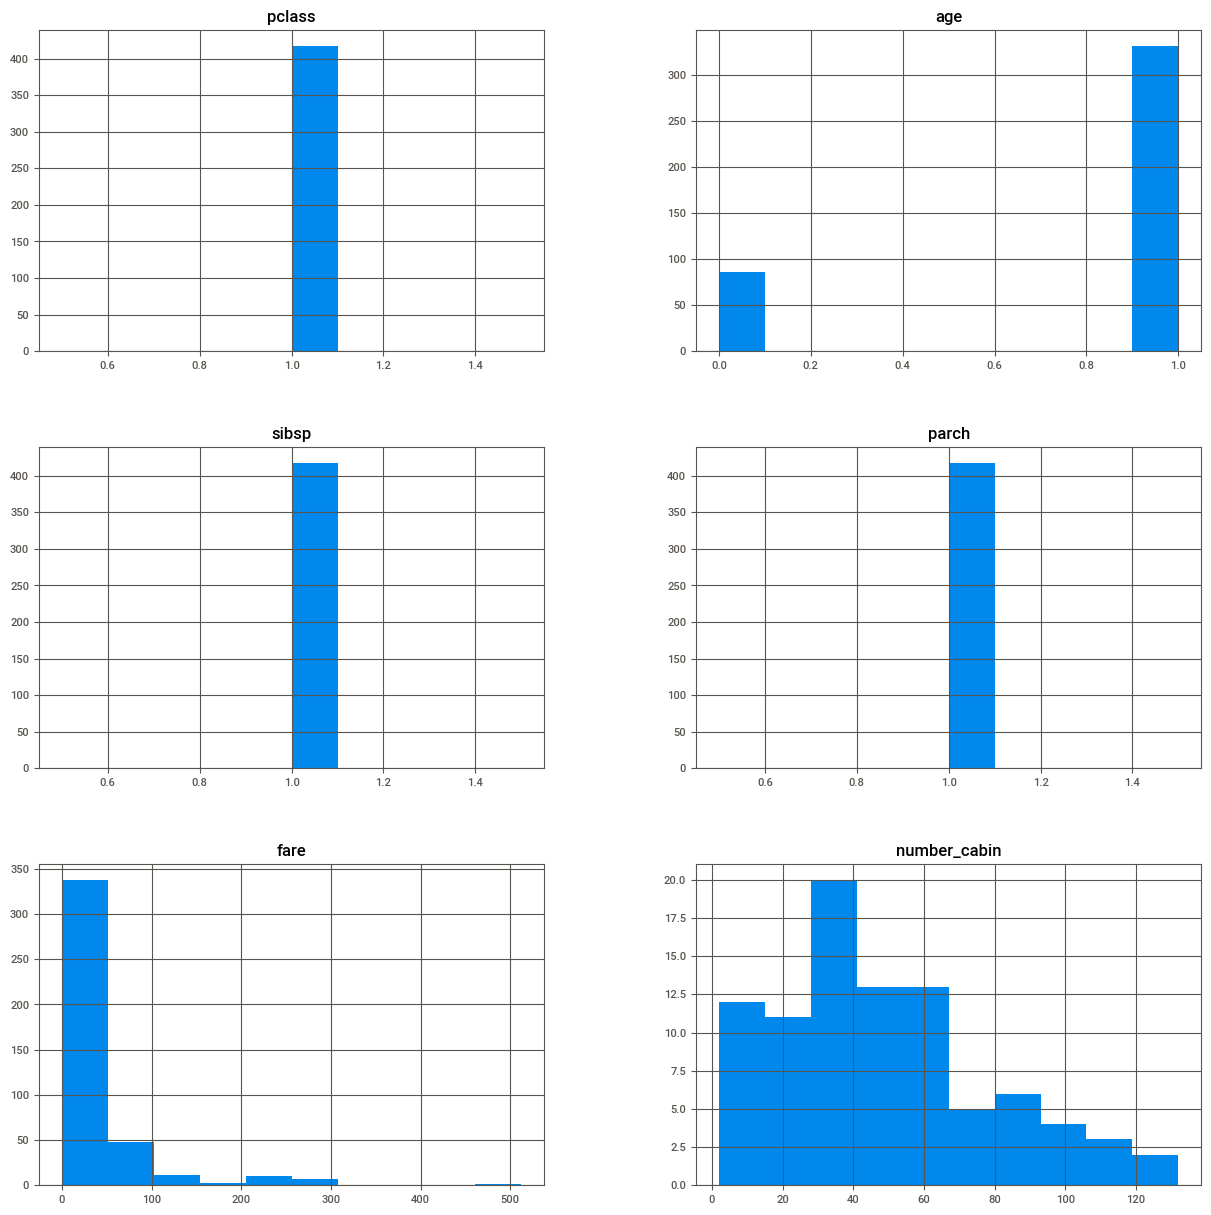

In [169]:
test_features.hist(figsize=(15,15));

In [170]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(test_features.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
pclass,0.000000
sex,0.000000
age,0.000000
sibsp,0.000000
parch,0.000000
fare,0.200000
embarked,0.000000
type_cabin,0.000000
number_cabin,78.700000


In [171]:
train_report = sv.analyze(train_data)
test_report = sv.analyze(test_features)

                                             |          | [  0%]   00:00 -> (? left)

                                             |          | [  0%]   00:00 -> (? left)

In [172]:
train_report.show_html('Train_report.html')
test_report.show_html('Test_report.html')

Report Train_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Report Test_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Model

## Data preparation

We examine three models `DecisionTreeClassifier`, `RandomForestClassifier`, `LogisticRegression` and `CatBoost`. 

Let's split the train data into training and validation sets.

In [173]:
features = train_data.drop('survived', axis = 1)
target = train_data['survived']
test_target_ml = test_target['Survived'] 
test_features = test_features.fillna(-999)

**Direct encoding**

In [174]:
ohe_features = features.select_dtypes(include='object').columns.to_list()
print(ohe_features)
num_features = features.select_dtypes(exclude='object').columns.to_list()
num_features

['sex', 'embarked', 'type_cabin']


['pclass', 'age', 'sibsp', 'parch', 'fare', 'number_cabin']

In [175]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features[ohe_features])

features[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features[ohe_features])

features = features.drop(ohe_features, axis=1)

In [176]:
test_features[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(test_features[ohe_features])

test_features = test_features.drop(ohe_features, axis=1)

/home/dolin/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Feature scaling**

In [177]:
scaler = StandardScaler()
features[num_features] = scaler.fit_transform(features[num_features])

scaler.fit(pd.DataFrame(features[num_features]))

StandardScaler()

In [178]:
features[num_features] = scaler.transform(features[num_features])
test_features[num_features] = scaler.transform(test_features[num_features])

In [179]:
features.head(10)

,pclass,age,sibsp,parch,fare,number_cabin,sex_male,embarked_Q,embarked_S,type_cabin_B,type_cabin_C,type_cabin_D,type_cabin_E,type_cabin_F,type_cabin_G,type_cabin_T
1,-0.375823,0.203604,0.881589,-0.603158,-0.064633,0.982625,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.375823,0.003953,0.881589,-0.603158,-0.308460,2.045716,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,-0.375823,1.268406,-0.708420,-0.603158,-0.325054,-0.108442,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10,3.419989,-2.059101,0.881589,0.765807,-0.796561,-1.227485,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,-0.375823,1.534607,-0.708420,-0.603158,-0.664479,1.486194,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21,1.522083,-0.062597,-0.708420,-0.603158,-0.846176,0.171319,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23,-0.375823,-0.461898,-0.708420,-0.603158,-0.544465,-1.227485,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,-0.375823,-1.060849,4.061607,2.134772,2.506169,-0.695940,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31,-0.375823,-0.461898,0.881589,-0.603158,0.944255,0.786793,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
52,-0.375823,0.935656,0.881589,-0.603158,0.008393,-0.472131,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Model training

To determine the best model, we use the Accuracy metric

### LogisticRegression

In [180]:
%%time
LogisticRegression_model = None
LogisticRegression_ac_mean_cv = 0
mi = 0

for mit in tqdm(range(100, 1100, 10)):
    model = LogisticRegression(random_state = RANDOM_STATE, solver='liblinear', 
                                class_weight='balanced', max_iter=mit)
    model.fit(features, target)
    ac_mean_cv = cross_val_score(model, features, target,cv=5,scoring = "accuracy").mean()
    if f1_mean_cv > LogisticRegression_ac_mean_cv:
        LogisticRegression_model = model
        LogisticRegression_ac_mean_cv = ac_mean_cv
        mi = mit

100%|██████████| 100/100 [00:01<00:00, 80.04it/s]

CPU times: user 1.24 s, sys: 19.2 ms, total: 1.25 s
Wall time: 1.25 s


In [181]:
print(f'Model hyperparameters: max_iter = {mi}')
print("Cross validation Accuracy-mean", LogisticRegression_ac_mean_cv)

Model hyperparameters: max_iter = 100
Cross validation Accuracy-mean 0.7573170731707318


### DecisionTreeClassifier

In [68]:
%%time

DecisionTreeClassifier_model = None
DecisionTreeClassifier_ac_mean_cv = 0
ms = 0
de = 0

for msl in tqdm(range(2, 18, 2)):
    for depth in range(1, 101):
        model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth,
                                       min_samples_leaf = msl, class_weight='balanced') 
        model.fit(features, target)
        ac_mean_cv = cross_val_score(model, features, target,cv=5,scoring = "accuracy").mean()
        if ac_mean_cv > DecisionTreeClassifier_ac_mean_cv:
            DecisionTreeClassifier_model = model
            DecisionTreeClassifier_ac_mean_cv = ac_mean_cv
            ms = msl
            de = depth

100%|██████████| 8/8 [00:09<00:00,  1.20s/it]

CPU times: user 9.6 s, sys: 10.6 ms, total: 9.61 s
Wall time: 9.61 s


In [69]:
print(f'Model hyperparameters: min_samples_leaf = {ms}; max_depth = {de}')
print('Cross validation Accuracy-mean', DecisionTreeClassifier_ac_mean_cv)

Model hyperparameters: min_samples_leaf = 6; max_depth = 8
Cross validation F1-mean 0.7720731707317073


### RandomForestClassifier

In [187]:
%%time

RandomForestClassifier_model = None
RandomForestClassifier_ac_mean_cv = 0
ms = 0
es = 0
de = 0
for msl in tqdm(range(2, 10, 2)):
    for est in range(10, 1000, 10):
        for depth in range(1, 16, 2):
            model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est,
                                            max_depth=depth,min_samples_leaf = msl,
                                            class_weight='balanced')
            model.fit(features, target)
            ac_mean_cv = cross_val_score(model, features, target,cv=5,scoring = "accuracy").mean()
            if ac_mean_cv > RandomForestClassifier_ac_mean_cv:
                es = est
                de = depth
                ms = msl
                RandomForestClassifier_model = model
                RandomForestClassifier_ac_mean_cv = ac_mean_cv

100%|██████████| 4/4 [1:16:14<00:00, 1143.67s/it]

CPU times: user 1h 16min 2s, sys: 12.3 s, total: 1h 16min 14s
Wall time: 1h 16min 14s


In [188]:
print(f'Model hyperparameters: min_samples_leaf = {ms}; max_depth = {de}; n_estimators = {es}')
print('Cross validation Accuracy-mean', RandomForestClassifier_ac_mean_cv)

Model hyperparameters: min_samples_leaf = 2; max_depth = 11; n_estimators = 500
Cross validation Accuracy-mean 0.8020731707317074


### CatBoost

In [227]:
Cat_model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=RANDOM_STATE
)

In [228]:
Cat_model.fit(
    features, target,
    eval_set=(test_features, test_target_ml),
    verbose=100,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.021347
0:	learn: 0.6796956	test: 0.6776427	best: 0.6776427 (0)	total: 371us	remaining: 371ms
100:	learn: 0.3009954	test: 0.4886132	best: 0.4536440 (71)	total: 40.4ms	remaining: 360ms
200:	learn: 0.2074899	test: 0.4669136	best: 0.4536440 (71)	total: 82.3ms	remaining: 327ms
300:	learn: 0.1573323	test: 0.4885205	best: 0.4536440 (71)	total: 117ms	remaining: 271ms
400:	learn: 0.1197613	test: 0.5408556	best: 0.4536440 (71)	total: 151ms	remaining: 225ms
500:	learn: 0.0889970	test: 0.5967513	best: 0.4536440 (71)	total: 183ms	remaining: 183ms
600:	learn: 0.0718009	test: 0.6638013	best: 0.4536440 (71)	total: 221ms	remaining: 146ms
700:	learn: 0.0587584	test: 0.7089075	best: 0.4536440 (71)	total: 253ms	remaining: 108ms
800:	learn: 0.0502640	test: 0.7776253	best: 0.4536440 (71)	total: 285ms	remaining: 70.9ms
900:	learn: 0.0415073	test: 0.8101850	best: 0.4536440 (71)	total: 317ms	remaining: 34.8ms
999:	learn: 0.0365048	test: 0.8629065	best: 0.4536440 (71)	total: 347ms	remaini

In [229]:
cv_params = Cat_model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
cv_data = cv(
    Pool(features, target),
    cv_params,
    verbose=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 0.6704458	test: 0.6712201	best: 0.6712201 (0)	total: 1.95ms	remaining: 1.95s
100:	learn: 0.2189052	test: 0.5067173	best: 0.4849374 (59)	total: 59ms	remaining: 525ms
200:	learn: 0.1147798	test: 0.5382183	best: 0.4849374 (59)	total: 114ms	remaining: 454ms
300:	learn: 0.0633662	test: 0.5604432	best: 0.4849374 (59)	total: 158ms	remaining: 368ms
400:	learn: 0.0390067	test: 0.5985029	best: 0.4849374 (59)	total: 217ms	remaining: 323ms
500:	learn: 0.0275343	test: 0.6316190	best: 0.4849374 (59)	total: 276ms	remaining: 275ms
600:	learn: 0.0203177	test: 0.6579657	best: 0.4849374 (59)	total: 329ms	remaining: 218ms
700:	learn: 0.0157251	test: 0.6784956	best: 0.4849374 (59)	total: 365ms	remaining: 155ms
800:	learn: 0.0129013	test: 0.6917696	best: 0.4849374 (59)	total: 448ms	remaining: 111ms
900:	learn: 0.0111165	test: 0.7055019	best: 0.4849374 (59)	total: 507ms	remaining: 55.7ms
999:	learn: 0.0098350	test: 0.7137408	best: 0.4849374 (59)	total: 566ms	remaining: 0us

b

In [230]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.79±0.02 on step 4


In [231]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.7923351158645277


In [232]:
predictions = Cat_model.predict(test_features)
predictions_probs = Cat_model.predict_proba(test_features)
print(predictions[:10])
print(predictions_probs[:10])

[0 1 0 0 1 0 1 0 1 0]
[[0.51906177 0.48093823]
 [0.14052286 0.85947714]
 [0.51906177 0.48093823]
 [0.54980481 0.45019519]
 [0.14052286 0.85947714]
 [0.54980481 0.45019519]
 [0.14109435 0.85890565]
 [0.54980481 0.45019519]
 [0.11343444 0.88656556]
 [0.54980481 0.45019519]]


# Test

In [215]:
print("Confusion matrix")
print(confusion_matrix(test_target_ml, LogisticRegression_model.predict(test_features)))
print("Accuracy:",accuracy_score(test_target_ml, LogisticRegression_model.predict(test_features)))

Confusion matrix
[[221  45]
 [108  44]]
Accuracy: 0.6339712918660287


In [214]:
print("Confusion matrix")
print(confusion_matrix(test_target_ml, DecisionTreeClassifier_model.predict(test_features)))
print("Accuracy:",accuracy_score(test_target_ml, DecisionTreeClassifier_model.predict(test_features)))

Confusion matrix
[[208  58]
 [  0 152]]
Accuracy: 0.861244019138756


In [189]:
print("Confusion matrix")
print(confusion_matrix(test_target_ml, RandomForestClassifier_model.predict(test_features)))
print("Accuracy:",accuracy_score(test_target_ml, RandomForestClassifier_model.predict(test_features)))

Confusion matrix
[[181  85]
 [  0 152]]
Accuracy: 0.7966507177033493


In [233]:
print("Confusion matrix")
print(confusion_matrix(test_target_ml, Cat_model.predict(test_features)))
print("Accuracy:",accuracy_score(test_target_ml, Cat_model.predict(test_features)))

Confusion matrix
[[223  43]
 [  0 152]]
Accuracy: 0.8971291866028708


# Final

Together we solved this problem. And the best model is CatBoost. You can try train own model like CatBoost, i think this data preparation not a good way for this model, beacuse in this case CatBoost don't need it. If this notebook was interested for you, would you mind, give me score, Theank you.

In [216]:
joblib.dump(LogisticRegression_model, "./LogisticRegression_model.joblib")
joblib.dump(DecisionTreeClassifier_model, "./DecisionTreeClassifier_model.joblib")
joblib.dump(RandomForestClassifier_model, "./RandomForestClassifier_model.joblib")
joblib.dump(Cat_model, "./Cat_model.joblib")

['./Cat_model.joblib']

In [234]:
submisstion = pd.DataFrame()
submisstion['PassengerId'] = test_target['PassengerId']
submisstion['Survived'] = Cat_model.predict(test_features)

In [236]:
submisstion.to_csv('submission.csv', index=False)